<a href="https://colab.research.google.com/github/Akshay-a-j/100DaysofCode/blob/main/surv_analysis(clinical_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines

In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
import copy
import gc

from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torchvision import models

from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Histopathology/LUAD_labels.csv", delimiter=",")
Data_details = data.describe()
data.loc[((data['tumor_stage'] =='stage i') | (data['tumor_stage'] =='stage ia') | (data['tumor_stage'] =='stage ib')) , 'STAGE_NUM'] = 1
data.loc[((data['tumor_stage'] =='stage ii') | (data['tumor_stage'] =='stage iia') | (data['tumor_stage'] =='stage iib')) , 'STAGE_NUM'] = 2
data.loc[((data['tumor_stage'] =='stage iiia') | (data['tumor_stage'] =='stage iiib')) , 'STAGE_NUM'] = 3
data.loc[data['tumor_stage'] =='stage iv', 'STAGE_NUM'] = 4
data.loc[data['gender'] =='male', 'GENDER'] = 1
data.loc[data['gender'] =='female', 'GENDER'] = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   submitter_id          480 non-null    object 
 1   age_at_diagnosis      480 non-null    float64
 2   survival_status       480 non-null    int64  
 3   survival_time_months  480 non-null    float64
 4   STAGE_NUM             480 non-null    float64
 5   GENDER                480 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 22.6+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad28b482d0>,
      dtype=object)

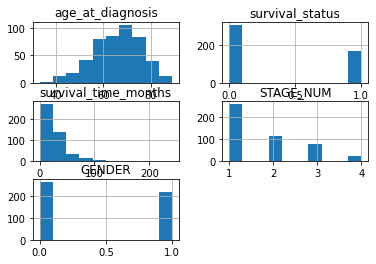

In [ ]:
data = data.dropna(subset=['submitter_id', 'age_at_diagnosis', 'survival_status', 'survival_time_months', 'STAGE_NUM','GENDER'])
data = data.reset_index()
data = data[['submitter_id','age_at_diagnosis', 'survival_status', 'survival_time_months', 'STAGE_NUM', 'GENDER']]
data.info()
data_details = data.describe()

df = data[(data['STAGE_NUM'] == 1) | (data['STAGE_NUM'] == 2) |(data['STAGE_NUM'] == 3) | (data['GENDER']==1) |(data['GENDER']==0)]

df.hist()

In [ ]:
df.isnull().sum()

submitter_id            0
age_at_diagnosis        0
survival_status         0
survival_time_months    0
STAGE_NUM               0
GENDER                  0
dtype: int64

In [ ]:
# for i in range(len(df)):
#   print(df.iloc[i])

In [ ]:
df.head()

,submitter_id,age_at_diagnosis,survival_status,survival_time_months,STAGE_NUM,GENDER
0,TCGA-05-5429,60.45,1,9.167,3.0,1.0
1,TCGA-44-2666,43.75,1,3.233,1.0,1.0
2,TCGA-44-2668,51.66,1,25.370,1.0,1.0
3,TCGA-44-3919,71.45,1,34.200,1.0,0.0
4,TCGA-44-4112,60.56,1,26.930,1.0,0.0


In [ ]:
X = df[["age_at_diagnosis", "survival_time_months", "survival_status"]]

In [ ]:
df = df[["STAGE_NUM", "GENDER"]]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
   
# creating one hot encoder object with categorical feature 0
# indicating the first column
columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        [0])],
                                      remainder='passthrough')
  
data = pd.DataFrame(np.array(columnTransformer.fit_transform(df), dtype = np.str))

In [ ]:
df = pd.concat([X, data], axis=1)
df.columns = ["age_at_diagnosis", "survival_time_months", "survival_status","Stage1", "Stage2", "Stage3", "Male", "Female" ]
df

,age_at_diagnosis,survival_time_months,survival_status,Stage1,Stage2,Stage3,Male,Female
0,60.45,9.1670,1,0.0,0.0,1.0,0.0,1.0
1,43.75,3.2330,1,1.0,0.0,0.0,0.0,1.0
2,51.66,25.3700,1,1.0,0.0,0.0,0.0,1.0
3,71.45,34.2000,1,1.0,0.0,0.0,0.0,0.0
4,60.56,26.9300,1,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
475,56.52,0.4333,0,0.0,1.0,0.0,0.0,0.0
476,67.78,20.1000,0,1.0,0.0,0.0,0.0,1.0
477,49.66,20.5700,0,0.0,0.0,1.0,0.0,1.0
478,74.58,59.9300,1,1.0,0.0,0.0,0.0,0.0


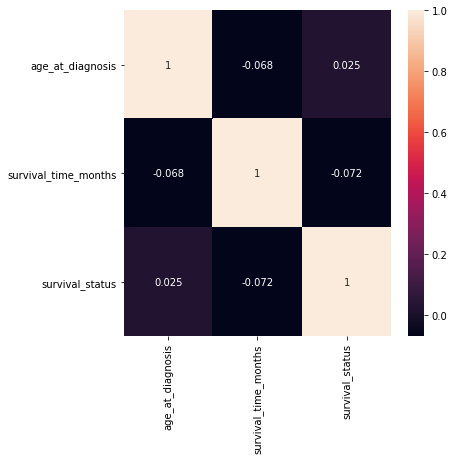

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
X

,age_at_diagnosis,survival_time_months,survival_status
0,60.45,9.1670,1
1,43.75,3.2330,1
2,51.66,25.3700,1
3,71.45,34.2000,1
4,60.56,26.9300,1
...,...,...,...
475,56.52,0.4333,0
476,67.78,20.1000,0
477,49.66,20.5700,0
478,74.58,59.9300,1


In [ ]:
X = np.array(df[["age_at_diagnosis","survival_time_months","Stage1", "Stage2", "Stage3", "Male", "Female"]], dtype= np.float32())#, ]])
Y = np.array(df[["survival_status"]])
print(X.shape, Y.shape)


inputs = torch.from_numpy(X)
labels = torch.from_numpy(Y)
print(inputs.shape, labels.shape)

(480, 7) (480, 1)
torch.Size([480, 7]) torch.Size([480, 1])


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, test_size= 0.2, random_state=0, shuffle = True)
print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape )

torch.Size([384, 7]) torch.Size([96, 7]) torch.Size([384, 1]) torch.Size([96, 1])


In [ ]:
# from sklearn import preprocessing
# def scalar_op(x):
#   scaler = preprocessing.StandardScaler()
#   arr_norm = scaler.fit_transform(x) 
#   m = x.mean(0, keepdim=True)
#   s = x.std(0, unbiased=False, keepdim=True)
#   x -= m
#   x /= s

#   torch.allclose(x, torch.from_numpy(arr_norm))
#   return x

def normz(x):
  xmax = torch.max(x)
  xmin = torch.min(x)
  x = (x - xmin)/(xmax - xmin)
  return x 

In [ ]:
# X_train = normz(X_train)
# X_test = normz(X_test)
# X_train

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(X_train, Y_train)
test_ds = TensorDataset(X_test, Y_test)

batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [ ]:
import torch.nn.functional as F
class Surv_nw(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Surv_nw, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):

        x = torch.tanh(self.hidden(x)) 
        #x = F.dropout(x)     # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [ ]:
net = Surv_nw(n_feature=1, n_hidden=16, n_output=1)     # define the network
# print(net)  # net architecture
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def accuracy_cox(hazards, labels):
    correct = 0
    # This accuracy is based on estimated survival events against true survival events
    hazardsdata = hazards.cpu().numpy().reshape(-1)
    median = np.median(hazardsdata)
    hazards_dichotomize = np.zeros([len(hazardsdata)], dtype=int)
    hazards_dichotomize[hazardsdata > median] = 1
    hazards_dichotomize[hazardsdata <= median] = 0
    labels = labels.data.cpu().numpy().reshape(-1)
    correct = np.sum(hazards_dichotomize == labels)
    return (correct/len(labels))

def cox_log_rank(hazards, labels, survtime_all):
    hazardsdata = hazards.cpu().numpy().reshape(-1)
    median = np.median(hazardsdata)
    hazards_dichotomize = np.zeros([len(hazardsdata)], dtype=int)
    hazards_dichotomize[hazardsdata > median] = 1
    survtime_all = survtime_all.data.cpu().numpy().reshape(-1)
    idx = hazards_dichotomize == 0
    labels = labels.data.cpu().numpy()
    T1 = survtime_all[idx]
    T2 = survtime_all[~idx]
    E1 = labels[idx]
    E2 = labels[~idx]
    results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    pvalue_pred = results.p_value
    return (pvalue_pred)


def CIndex(hazards, labels, survtime_all):
    labels = labels.data.cpu().numpy()
    concord = 0.
    total = 0.
    N_test = labels.shape[0]
    labels = np.asarray(labels, dtype=bool)
    for i in range(N_test):
        if labels[i] == 1:
            for j in range(N_test):
                if survtime_all[j] > survtime_all[i]:
                    total = total + 1
                    if hazards[j] < hazards[i]:
                        concord = concord + 1
                    elif hazards[j] < hazards[i]:
                        concord = concord + 0.5

    return (concord / total)


def CIndex_lifeline(hazards, labels, survtime_all):
     survtime_all = survtime_all.cpu().numpy().reshape(-1)
     labels = labels.data.cpu().numpy()# X = iter(trainloader).next()
     hazards = hazards.cpu().numpy().reshape(-1)
     return(concordance_index(survtime_all, -hazards, labels))

In [ ]:
def test(model, dataloader, verbose):
  
  model.eval()
  lbl_pred_all = None
  lbl_all = None
  survtime_all = None
  loss_nn_sum = 0
  iter = 0
  gc.collect()
  for i_batch, sample in enumerate(dataloader, 0):
      # Generate predictions
      X, Y = sample
      labels = Y.cuda()
      survtime = X[:, 1]
      age, gender, survtime, stg = X[:, 0], X[:, 1], X[:,2], X[:,3]
      age = torch.unsqueeze(age, 1).cuda()
     
      #inputs = torch.cat([age[None, :], gender[None, :], stg[None, :]], dim=0)
      #inputs = torch.transpose(torch.cat([age[None, :], gender[None, :], stg[None, :]], dim=0), 1, 0)
      #inputs = torch.cat((torch.unsqueeze(X[:,0], 1), X[:, 2:]), dim=1)
      pred = model(age.float().cuda())

      if iter == 0:
          lbl_pred_all = pred
          survtime_all = survtime
          lbl_all = labels
          
  
      else:
          lbl_pred_all = torch.cat([lbl_pred_all, pred])
          lbl_all = torch.cat([lbl_all, labels])
          survtime_all = torch.cat([survtime_all, survtime])
  
  
      current_batch_len = len(survtime)
      
      R_matrix_train = np.zeros([current_batch_len, current_batch_len], dtype=float)
      

      for i in range(current_batch_len):
          for j in range(current_batch_len):
              R_matrix_train[i, j] = survtime[j] >= survtime[i]
  
      train_R = torch.FloatTensor(R_matrix_train)
      train_R = train_R.cuda()
      train_ystatus = labels
  
      theta = pred.reshape(-1)
      exp_theta = torch.exp(theta)
      loss_nn = -torch.mean( (theta - torch.log(torch.sum( exp_theta*train_R ,dim=1))) * train_ystatus.float() )
      
      l1_reg = None
      for W in model.parameters():
          if l1_reg is None:
              l1_reg = torch.abs(W).sum()
          else:
              l1_reg = l1_reg + torch.abs(W).sum()  # torch.abs(W).sum() is equivalent to W.norm(1)

      loss = loss_nn + 1e-5 * l1_reg
      loss_nn_sum = loss_nn_sum + loss_nn.data.item()
      iter += 1

  acc_test = accuracy_cox(lbl_pred_all.data, lbl_all)
  pvalue_pred = cox_log_rank(lbl_pred_all.data, lbl_all, survtime_all)
  c_index = CIndex_lifeline(lbl_pred_all.data, lbl_all, survtime_all)
  if verbose > 0:
      print('\n[Testing]\t loss (nn):{:.4f}'.format(loss_nn_sum),
                    'c_index: {:.4f}, p-value: {:.3e}'.format(c_index, pvalue_pred))  


  return(loss.data.item(), loss_nn_sum, acc_test, pvalue_pred, c_index, lbl_pred_all.data.cpu().numpy().reshape(-1), survtime_all)

In [ ]:
def fit(num_epochs, model, lr, measure=1, verbose=1):
    c_index_list = {}
    c_index_all = {}
    loss_nn_all = {}
    pvalue_all = {}
    acc_train_all = {}

    c_index_list['train'] = []
    c_index_list['test'] = []

    loss_nn_all['train'] = []
    loss_nn_all['test'] = []

    pvalue_all['train'] = []
    pvalue_all['test'] = []

    c_index_all['train'] = []
    c_index_all['test'] = []

    acc_train_all['train'] = []
    acc_train_all['test'] = []

    c_index_best = 0
    test_ci_loss = []


    for epoch in range(num_epochs):
        model = model.cuda()
        model.train()
        lbl_pred_all = None
        lbl_all = None
        survtime_all = None
        loss_nn_sum = 0
        iter = 0
        gc.collect()
        
        for i_batch, sample in enumerate(train_dl, 0):
            
            # Generate predictions
            X, Y = sample
            #inputs = X.cuda()
            labels = Y.cuda()
            survtime = X[:, 1]
            age, gender, survtime, stg = X[:, 0], X[:, 1], X[:,2], X[:,3]
            age = torch.unsqueeze(age, 1).cuda()
            #inputs = torch.cat([age[None, :], gender[None, :], stg[None, :]], dim=1)
            #inputs = torch.transpose(torch.cat([age[None, :], gender[None, :], stg[None, :]], dim=0), 1, 0)
            #inputs = torch.cat((torch.unsqueeze(X[:,0], 1), X[:, 2:]), dim=1)

            opt.zero_grad()
            pred = model(age.float().cuda())

            if iter == 0:
                lbl_pred_all = pred
                survtime_all = survtime
                lbl_all = labels
                
        
            else:
                lbl_pred_all = torch.cat([lbl_pred_all, pred])
                lbl_all = torch.cat([lbl_all, labels  ])
                survtime_all = torch.cat([survtime_all, survtime])
        
        
            current_batch_len = len(survtime)
            R_matrix_train = np.zeros([current_batch_len, current_batch_len], dtype=float)
            
            for i in range(current_batch_len):
                for j in range(current_batch_len):
                    R_matrix_train[i, j] = survtime[j] >= survtime[i]
        
            train_R = torch.FloatTensor(R_matrix_train)
            train_R = train_R.cuda()
            train_ystatus = labels
        
            theta = pred.reshape(-1)
            exp_theta = torch.exp(theta)
            loss_nn = -torch.mean( (theta - torch.log(torch.sum( exp_theta*train_R ,dim=1))) * train_ystatus.float() )
           
            l1_reg = None
            for W in model.parameters():
                if l1_reg is None:
                    l1_reg = torch.abs(W).sum()
                else:
                    l1_reg = l1_reg + torch.abs(W).sum()  # torch.abs(W).sum() is equivalent to W.norm(1)

            loss = loss_nn + 1e-5 * l1_reg
            loss_nn_sum = loss_nn_sum + loss_nn.data.item()
    # ===================backward====================
            loss.backward()
            opt.step()
            
            iter += 1
            torch.cuda.empty_cache()
            

        print('epoch:{:.1f}'.format(epoch))
        if measure or epoch == (epoch - 1):
          acc_train = accuracy_cox(lbl_pred_all.data, lbl_all)
          pvalue_pred = cox_log_rank(lbl_pred_all.data, lbl_all, survtime_all)
          c_index = CIndex_lifeline(lbl_pred_all.data, lbl_all, survtime_all)
                
          c_index_list['train'].append(c_index)
          
          if c_index > c_index_best:
              c_index_best = c_index
          if verbose > 0:
              print("epcoh:", epoch )
              print('\n[Training]\t loss (nn):{:.4f}'.format(loss_nn_sum),
                    'c_index: {:.4f}, p-value: {:.3e}'.format(c_index, pvalue_pred))
          
          pvalue_all['train'].append(pvalue_pred)
          c_index_all['train'].append(c_index)
          loss_nn_all['train'].append(loss_nn_sum)
          acc_train_all['train'].append(acc_train)

          test_loss, loss_nn_sum_test, acc_test, pvalue_pred_test, c_index_pred, lbl_pred_all, surv_time_all= test(model, test_dl, verbose)
              
          pvalue_all['test'].append(pvalue_pred_test)
          loss_nn_all['test'].append(loss_nn_sum_test)
          acc_train_all['test'].append(acc_test)  
          c_index_list['test'].append(c_index_pred)


    return(loss_nn_all, pvalue_all, c_index_all, c_index_list, acc_train_all)

In [ ]:
result = fit(100, net, 0.0001, measure=1, verbose=1)

epoch:0.0
epcoh: 0

[Training]	 loss (nn):14.2662 c_index: 0.5095, p-value: 6.910e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:1.0
epcoh: 1

[Training]	 loss (nn):14.2325 c_index: 0.4879, p-value: 5.713e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:2.0
epcoh: 2

[Training]	 loss (nn):14.2202 c_index: 0.4989, p-value: 5.411e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:3.0
epcoh: 3

[Training]	 loss (nn):14.2129 c_index: 0.5523, p-value: 5.063e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:4.0
epcoh: 4

[Training]	 loss (nn):14.2322 c_index: 0.4466, p-value: 2.581e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:5.0
epcoh: 5

[Training]	 loss (nn):14.2180 c_index: 0.5013, p-value: 4.049e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000, p-value: nan
epoch:6.0
epcoh: 6

[Training]	 loss (nn):14.2616 c_index: 0.4936, p-value: 6.577e-01

[Testing]	 loss (nn):2.6393 c_index: 0.5000